# File and libraries

In [35]:
import pandas as pd
import numpy as np

filepath=r'dataset/df_ecom_2_6_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

sample_filepath=f"{filepath}_sample.csv"
test_sample_filepath=f"{filepath}_test_sample.csv"
train_sample_filepath=f"{filepath}_train_sample.csv"

file_tag = "Multicategory Store"

# DSLabs functions

In [2]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [36]:
%run "data_functions.py"


data_functions loaded


# Load

In [37]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    df = df.groupby('day').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    test = test.groupby('day').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    train = train.groupby('day').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)

    # data=data.sample(frac=0.05, replace=False)
    # test=test.sample(frac=0.05, replace=False)
    # train=train.sample(frac=0.05, replace=False)
    
    
else:
    # df=pd.read_csv(f"{filepath}.csv")  
    # test= pd.read_csv(test_filepath)
    # train= pd.read_csv(train_filepath)

    # use 10% sample file when heavy processing
    df=pd.read_csv(sample_filepath)
    test= pd.read_csv(test_sample_filepath)
    train= pd.read_csv(train_sample_filepath)
 

 
target='is_purchase'
eval_metric_1='precision'
eval_metric_2='f2'
vars: list[str] = df.columns.to_list()
labels: list = list(df[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16977 entries, 0 to 16976
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                16977 non-null  float64
 1   is_purchase          16977 non-null  int64  
 2   activity_in_session  16977 non-null  float64
 3   week_of_month        16977 non-null  int64  
 4   is_weekend           16977 non-null  int64  
 5   day                  16977 non-null  int64  
 6   brand_value          16977 non-null  float64
 7   time_of_day_sin      16977 non-null  float64
 8   time_of_day_cos      16977 non-null  float64
 9   day_of_week_sin      16977 non-null  float64
 10  day_of_week_cos      16977 non-null  float64
 11  hour_sin             16977 non-null  float64
 12  hour_cos             16977 non-null  float64
 13  min_sin              16977 non-null  float64
 14  min_cos              16977 non-null  float64
dtypes: float64(11), int64(4)
memory usage: 2.

# Distribution Check

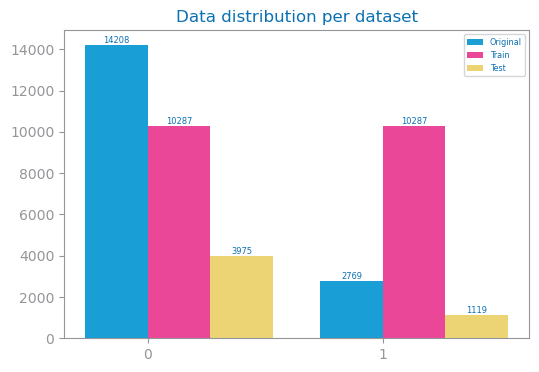

In [38]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Original": [
        len(df[df[target] == 0]),  # Assuming 0 is the negative class
        len(df[df[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

# Model Evaluation

In [39]:
k_eval=100

In [40]:
if evaluate==True:
    
    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')

Train#=20574 Test#=5094
Labels=[0, 1]


## recall evaluation

## recall study

KNN best with k=15 and chebyshev


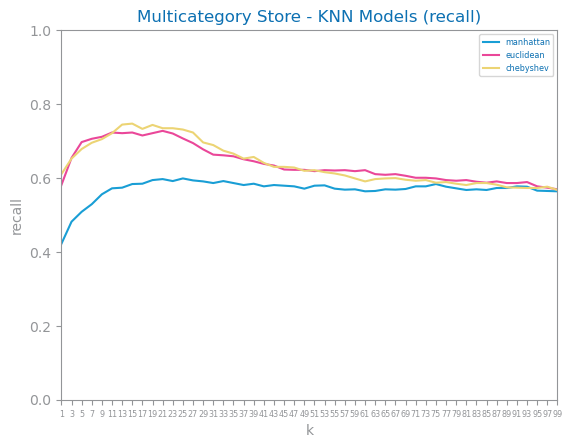

In [41]:
best_model_recall, recall_params = knn_study(trnX, trnY, tstX, tstY, k_max=k_eval, metric='recall',file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{recall_params["metric"]}_study.png')
show()

## recall best model

<Figure size 640x480 with 0 Axes>

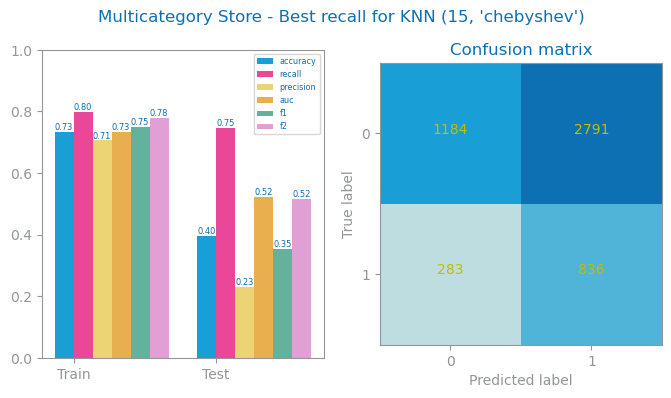

In [42]:
prd_trn: array = best_model_recall.predict(trnX)
prd_tst: array = best_model_recall.predict(tstX)
figure()
plot_evaluation_results(recall_params, trnY, prd_trn, tstY, prd_tst, labels,file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{recall_params["name"]}_best_{recall_params["metric"]}_eval.png')
show()

## recall overfitting

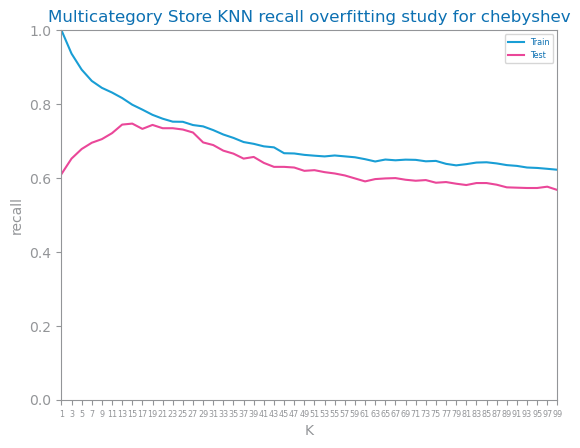

In [44]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = recall_params["params"][1]
K_MAX = k_eval
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
eval_metric: str = recall_params['metric']
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} KNN {recall_params['metric']} overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_knn_{recall_params['metric']}_overfitting.png")
show()

# precision evaluation

## precision study

KNN best with k=75 and manhattan


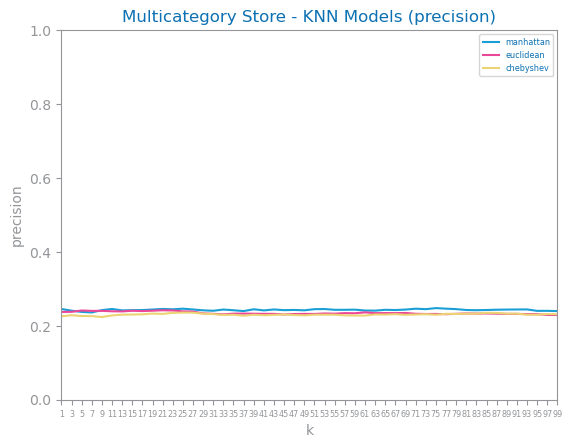

In [47]:
best_model_prec, prec_params = knn_study(trnX, trnY, tstX, tstY, k_max=k_eval, metric='precision', file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{prec_params["metric"]}_study.png')
show()

## precision best model

<Figure size 640x480 with 0 Axes>

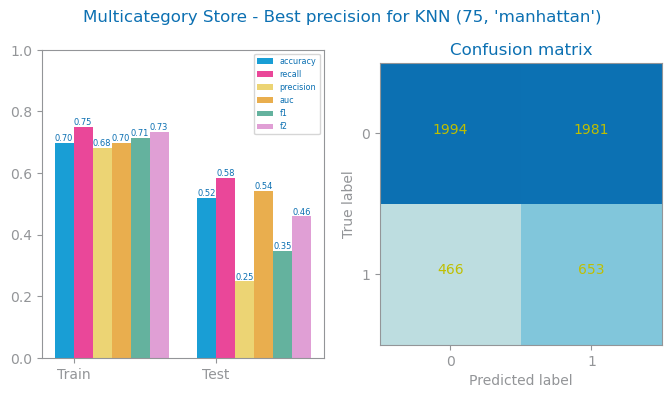

In [48]:
prd_trn: array = best_model_prec.predict(trnX)
prd_tst: array = best_model_prec.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
show()

## precision overfitting

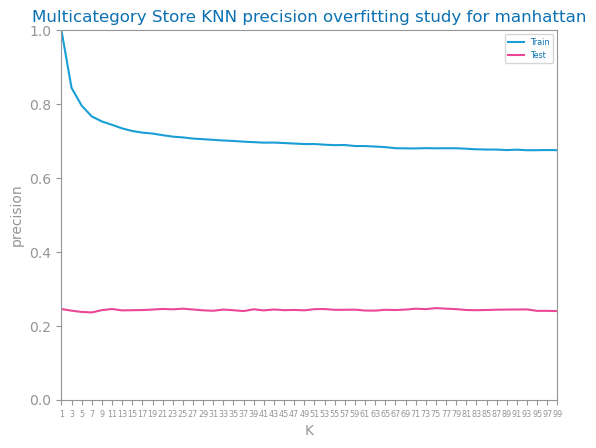

In [49]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = prec_params["params"][1]
K_MAX = k_eval
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
eval_metric: str = prec_params['metric']
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} KNN {eval_metric} overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_knn_{eval_metric}_overfitting.png")
show()

# f2 evaluation

## f2 Study

KNN best with k=21 and euclidean


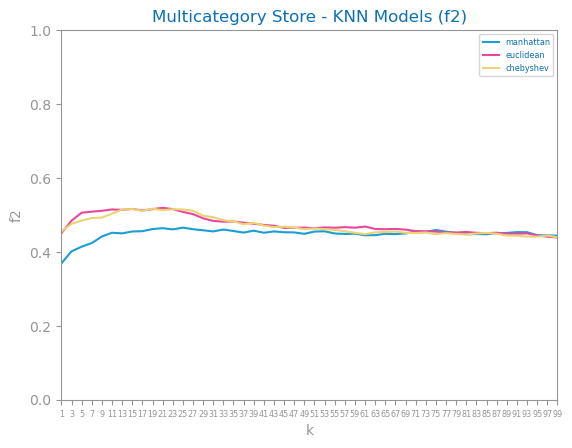

In [50]:
best_model_f2, f2_params = knn_study(trnX, trnY, tstX, tstY, k_max=k_eval, metric='f2', file_tag=file_tag)


savefig(f'images/{file_tag}_knn_{f2_params["metric"]}_study.png')
show()

## f2 best model

<Figure size 640x480 with 0 Axes>

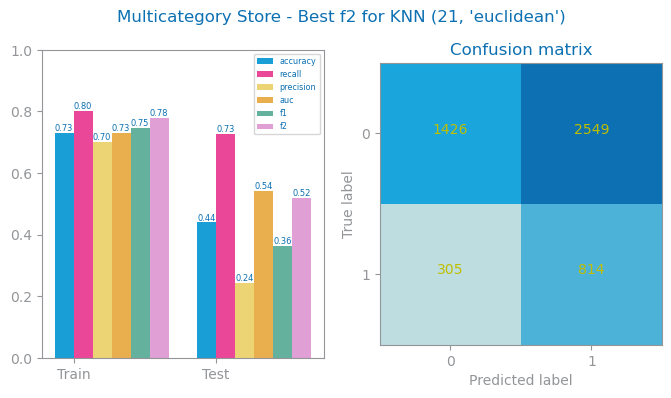

In [51]:
prd_trn: array = best_model_f2.predict(trnX)
prd_tst: array = best_model_f2.predict(tstX)
figure()
plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
show()

## f2 Overfitting

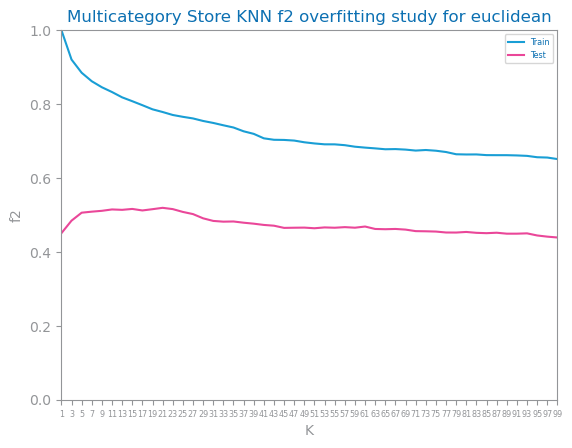

In [53]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = f2_params["params"][1]
K_MAX = k_eval
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
eval_metric: str = f2_params['metric']
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} KNN {f2_params['metric']} overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric_2),
    percentage=True,
)
savefig(f"images/{file_tag}_knn_{f2_params['metric']}_overfitting.png")
show()

# Analysis

- Traffic source and medium with higher importance
- overfitting from level 3
